**Load Libraries**

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import plotly.express as px
from umap import UMAP
from difflib import SequenceMatcher
import numpy as np
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from sklearn.preprocessing import StandardScaler

In [2]:
import warnings
warnings.filterwarnings('ignore')

**Data Loading and Initial Exploration**

In [3]:
df = pd.read_csv('pseudoProcess.csv')

In [4]:
# Convert timestamp to datetime
df['readableTimestamp'] = pd.to_datetime(df['readableTimestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')


In [5]:
print(df['readableTimestamp'].min())
print(df['timestamp'].min())

1970-01-25 10:59:24+00:00
1970-01-25 10:59:24


Check for these timestamps

In [6]:
df['readableTimestamp'].dt.year.value_counts()

2024    2578827
2023     653614
2022     411049
2021      11136
1970       7568
Name: readableTimestamp, dtype: int64

In [7]:
# Remove date before 2024
df = df[df['readableTimestamp'].dt.year >= 2024]

In [8]:
# Handle missing or incorrect data (here we drop missing)
df= df.dropna()

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2565753 entries, 0 to 3662193
Data columns (total 9 columns):
 #   Column             Dtype              
---  ------             -----              
 0   iOSVersion         object             
 1   iOSModel           object             
 2   pid                float64            
 3   readableTimestamp  datetime64[ns, UTC]
 4   timestamp          datetime64[ns]     
 5   id                 int64              
 6   device             object             
 7   scan               object             
 8   procName           object             
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 195.8+ MB
None


In [9]:
# Basic info about the dataset
print(f"Total rows: {len(df)}")
print(f"Number of unique process names: {df['procName'].nunique()}")

# Analyze process names
process_counts = df['procName'].value_counts()
print(f"\nTotal unique process names: {len(process_counts)}")
print("\nTop 10 most common processes:")
print(process_counts.head(10))


Total rows: 2565753
Number of unique process names: 1519

Total unique process names: 1519

Top 10 most common processes:
MTLCompilerService             65263
com.apple.WebKit.WebContent    22421
extensionkitservice            20020
CommCenter                     16281
com.apple.datamigrator         15747
backupd                        15718
kernel                         15479
CategoriesService              15049
duetexpertd                    12586
filecoordinationd              12065
Name: procName, dtype: int64


In [10]:
# Analyze processes per scan
processes_per_scan = df.groupby(['device', 'scan'])['procName'].count()
print("\nSummary of processes per scan:")
print(processes_per_scan.describe())

# Check for scans with only one process
single_process_scans = processes_per_scan[processes_per_scan == 1]
print(f"\nNumber of scans with only one process: {len(single_process_scans)}")
if len(single_process_scans) > 0:
    print("Scans with only one process:")
    print(single_process_scans)

# Check for multiple process lists within a scan
def check_multiple_lists(group):
    timestamps = group['readableTimestamp'].nunique()
    return timestamps > 1

multiple_lists = df.groupby(['device', 'scan']).apply(check_multiple_lists)
print(f"\nNumber of scans with multiple process lists: {multiple_lists.sum()}")
if multiple_lists.sum() > 0:
    print("Scans with multiple process lists:")
    print(multiple_lists[multiple_lists])


Summary of processes per scan:
count       910.000000
mean       2819.508791
std       16792.266809
min         193.000000
25%         385.000000
50%         508.000000
75%         983.500000
max      422302.000000
Name: procName, dtype: float64

Number of scans with only one process: 0

Number of scans with multiple process lists: 203
Scans with multiple process lists:
device    scan    
Device1   Scan423     True
          Scan432     True
          Scan435     True
          Scan442     True
          Scan447     True
          Scan450     True
          Scan460     True
          Scan471     True
          Scan480     True
          Scan500     True
          Scan501     True
          Scan508     True
          Scan514     True
          Scan527     True
          Scan541     True
          Scan546     True
          Scan549     True
          Scan551     True
          Scan559     True
          Scan578     True
          Scan579     True
          Scan580     True
          Sca

In [11]:
# Identify rare processes
rare_processes = process_counts[process_counts == 1].index.tolist()
print(f"\nNumber of rare processes (appearing only once): {len(rare_processes)}")
print("Sample of rare processes:", rare_processes[:10])


Number of rare processes (appearing only once): 67
Sample of rare processes: ['NumbersSpotlightExtension', 'RTLplusPushNotification', 'TooGoodToGo', 'com.apple.BarcodeSupport.ParsingService', 'Core', 'de-lieferando-notification-serv', 'zooplus', 'com.apple.DataDetectorsUI.Actio', 'WaterSort', 'Minesweeper']


**Time-based analysis**

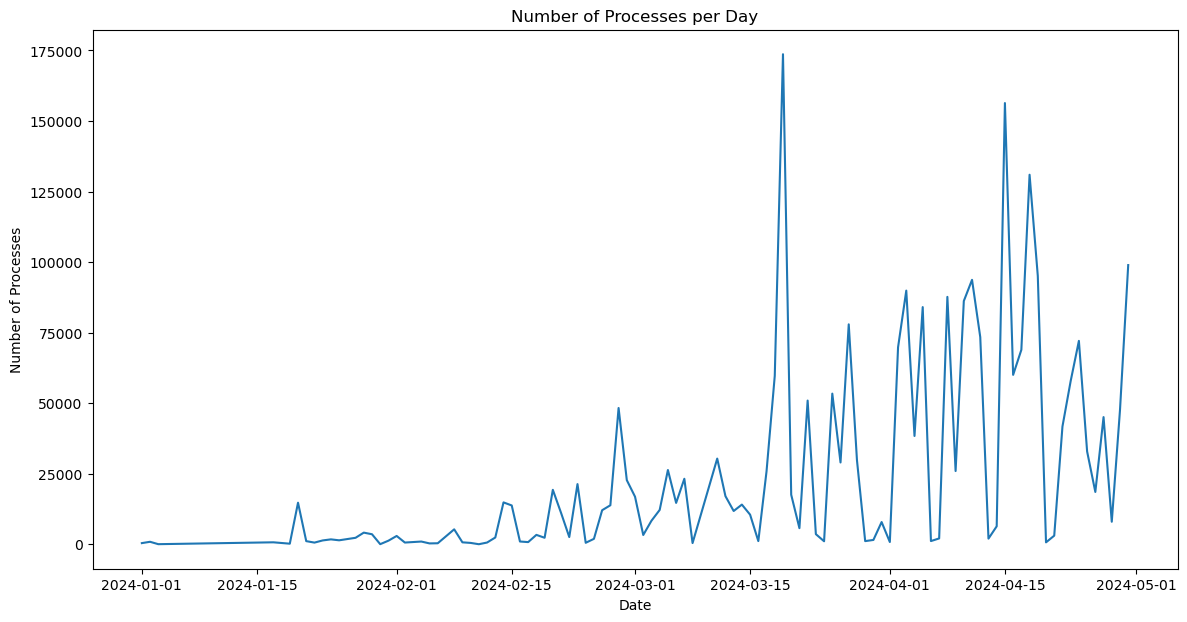

In [12]:
df['date'] = df['timestamp'].dt.date
# Number of processes over time
plt.figure(figsize=(14,7))
temp_df = df.groupby('date').size().reset_index(name='count')
sns.lineplot(x='date', y='count', data=temp_df)
plt.xlabel('Date')
plt.ylabel('Number of Processes')
plt.title('Number of Processes per Day')
plt.show()

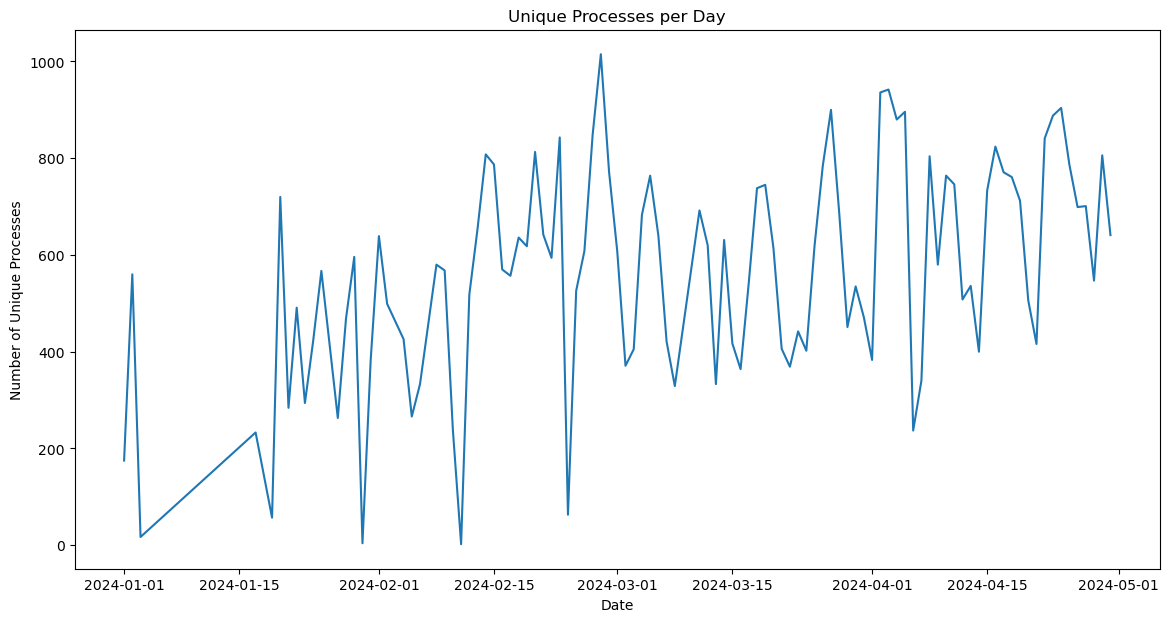

In [13]:
# Analyze process creation over time
plt.figure(figsize=(14, 7))
# Number of unique processes per day
daily_process_counts = df.groupby('date')['procName'].nunique()
daily_process_counts.plot()
plt.title('Unique Processes per Day')
plt.xlabel('Date')
plt.ylabel('Number of Unique Processes')
plt.show()

In [14]:
# Calculate the number of unique processes per day
daily_process_counts = df.groupby('date')['procName'].nunique().reset_index()
daily_process_counts.columns = ['Date', 'UniqueProcesses']

# Create the bar chart using Plotly Express with color and style options
fig = px.bar(daily_process_counts, x='Date', y='UniqueProcesses', 
             title='Unique Processes per Day',
             labels={'Date': 'Date', 'UniqueProcesses': 'Number of Unique Processes'},
             text='UniqueProcesses',
             color='UniqueProcesses',  # Color bars by the count of unique processes
             color_continuous_scale='Viridis')  # Choose a color scale

# Customize layout for a more colorful appearance
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Number of Unique Processes',
    plot_bgcolor='white',  # Background color of the plotting area
    paper_bgcolor='white',     # Background color of the entire figure
    title_font=dict(size=20, color='darkblue'),
    xaxis=dict(
        tickangle=-90,            # Angle of x-axis tick labels for better readability
        title_font=dict(size=16),
        tickfont=dict(size=14)
    ),
    yaxis=dict(
        title_font=dict(size=16),
        tickfont=dict(size=14)
    ),
    showlegend=False            # Hide legend if not necessary
)

# Display the bar chart
fig.show()

In [15]:
# Analyze process name patterns
def extract_prefix(name):
    return name.split('.')[0] if '.' in name else name

process_prefixes = df['procName'].apply(extract_prefix)
prefix_counts = process_prefixes.value_counts()

print("\nTop 10 process name prefixes:")
print(prefix_counts.head(10))


Top 10 process name prefixes:
com                          176814
MTLCompilerService            65263
extensionkitservice           20020
CommCenter                    16281
backupd                       15718
kernel                        15479
CategoriesService             15049
duetexpertd                   12586
filecoordinationd             12065
WiFiCloudAssetsXPCService     11786
Name: procName, dtype: int64


**Process Persistence:**

We analyzed which processes appear in a high percentage of scans, as persistent processes could be either essential system processes or potentially malicious software.

In [16]:
# Additional analysis: Process persistence
process_persistence = df.groupby('procName')['scan'].nunique() / df['scan'].nunique()


In [17]:
process_persistence.head()

procName
(backupd)     0.001099
(fish)        0.001099
(ps)          0.038462
(taskinfo)    0.002198
-s            0.001099
Name: scan, dtype: float64

In [18]:
persistent_processes = process_persistence[process_persistence > 0.95]
print("\nProcesses present in over 95% of scans:")
print(persistent_processes.head(10))

# Convert to DataFrame for Plotly Express
persistent_processes_df = persistent_processes.reset_index()
persistent_processes_df.columns = ['ProcessName', 'Persistence']

# Create the bar chart using Plotly Express
fig = px.bar(persistent_processes_df, x='ProcessName', y='Persistence',
             title='Processes Present in Over 95% of Scans',
             labels={'ProcessName': 'Process Name', 'Persistence': 'Persistence'},
             text='Persistence')

# Display the bar chart
fig.show()

# # Visualize process persistence
# plt.figure(figsize=(20, 6))
# persistent_processes.plot(kind='bar')
# plt.title('Process Persistence Across Scans')
# plt.xlabel('Process Name')
# plt.ylabel('Fraction of Scans Present')
# plt.xticks(rotation=90)
# plt.tight_layout()


Processes present in over 95% of scans:
procName
AppleCredentialManagerDaemon     0.995604
AssetCacheLocatorService         0.961538
CMFSyncAgent                     0.992308
CacheDeleteAppContainerCaches    0.985714
CalendarWidgetExtension          0.984615
CommCenter                       1.000000
ContextService                   1.000000
HeuristicInterpreter             0.995604
IMDPersistenceAgent              0.998901
MTLCompilerService               0.987912
Name: scan, dtype: float64


**Anomaly Detection**
1. String Similarity in Process Names: Detect process names that are similar to benign processes but have slight deviations.
3. Time-based Anomalies: Identify processes that deviate from the usual pattern over time

In [19]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

# Example to find similar process names
def find_similar_processes(data):
    process_names = data['procName'].unique()
    similar_process_pairs = []

    for i, name1 in enumerate(process_names):
        for name2 in process_names[i+1:]:
            if name1 != name2 and similar(name1, name2) > 0.8:
                similar_process_pairs.append((name1, name2))

    return similar_process_pairs

similar_processes = find_similar_processes(df)
print("Similar Process Pairs:", similar_processes)


Similar Process Pairs: [('dprivacyd', 'adprivacyd'), ('backupd', '(backupd)'), ('com.apple.SafariServices.Conten', 'com.apple.SafariServices.ContentBlockerLoader'), ('com.apple.SafariServices.Conten', 'com.apple.SafariServices.Content'), ('PFLHRPeriodPredCK', 'PFLHRPeriodPredMLH'), ('healthappd', 'healthd'), ('CoreSpotlightImportExtension1_i', 'CoreSpotlightImportExtension1_iOS'), ('CoreSpotlightImportExtension1_i', 'CoreSpotlightImportExtension1_iO'), ('EAUpdaterService', 'UARPUpdaterServiceHID'), ('EAUpdaterService', 'UARPUpdaterServiceAFU'), ('adattributiond', 'spaceattributiond'), ('adattributiond', 'attributionkitd'), ('tvremoted', 'remoted'), ('MTLCompilerService', 'ANECompilerService'), ('ProactiveShareSheetLighthouseBa', 'ProactiveShareSheetLighthouseBackgroundPlugin'), ('ProactiveShareSheetLighthouseBa', 'ProactiveShareSheetLighthouseBac'), ('MetricsExtension', 'ServiceExtension'), ('UARPUpdaterServiceHID', 'UARPUpdaterServiceUSBPD'), ('UARPUpdaterServiceHID', 'UARPUpdaterServ

In [20]:
#! pip install hdbscan umap-learn

### Explanation of the Plot

#### Overview
The plot visualizes the clustering of process names using UMAP for dimensionality reduction and HDBSCAN for clustering. The scatter plot displays the embeddings of different processes, with colors representing different clusters. Outliers are highlighted in red and labeled for easier identification.

#### Steps and Methods Used

1. **Sentence Transformer for Embeddings:**
   - **Purpose:** Sentence transformers convert textual data (process names) into dense vector representations (embeddings) that capture semantic meaning.
   - **Pros:** High-quality embeddings that understand the context and semantics of the process names, enabling better clustering performance.
   - **Cons:** Computationally intensive, especially for large datasets. The quality of embeddings depends on the pre-trained model used.

2. **HDBSCAN for Clustering:**
   - **Purpose:** HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) clusters the embeddings based on density.
   - **Pros:** Identifies clusters of varying densities, can find a variable number of clusters, and effectively handles noise (outliers).
   - **Cons:** Choice of hyperparameters (e.g., minimum cluster size) can significantly affect results. Computationally intensive for large datasets.

3. **UMAP for Visualization:**
   - **Purpose:** UMAP (Uniform Manifold Approximation and Projection) reduces high-dimensional embeddings to two dimensions for visualization.
   - **Pros:** Preserves both local and global structure of the data, produces more interpretable 2D visualizations compared to other methods like t-SNE.
   - **Cons:** Choice of parameters (e.g., `n_neighbors`, `min_dist`) can impact the visual representation. May require tuning for optimal results.

#### Plot Details
- **Axes:** The plot has two dimensions (UMAP Dimension 1 and UMAP Dimension 2) representing the reduced dimensions of the high-dimensional embeddings.
- **Colors:** Each point is colored based on its cluster label, determined by HDBSCAN. The color bar on the right indicates the cluster labels.
- **Outliers:** Outliers identified by HDBSCAN are marked in red with black edges, and some are annotated with their process names.
- **Annotations:** A random subset of process names is annotated to avoid cluttering the plot. Annotations help in understanding which processes form clusters or are marked as outliers.

### Pros and Cons of the Approach

#### Pros
1. **Semantic Understanding:** Using sentence transformers ensures that the embeddings capture semantic meaning, improving clustering quality.
2. **Robust Clustering:** HDBSCAN effectively identifies clusters of varying densities and handles noise, making it suitable for real-world data with outliers.
3. **Effective Visualization:** UMAP preserves the structure of high-dimensional data in a 2D space, providing an interpretable visualization of clusters.

#### Cons
1. **Computationally Intensive:** Both sentence transformers and HDBSCAN are computationally expensive, especially for large datasets.
2. **Parameter Sensitivity:** UMAP and HDBSCAN require careful tuning of parameters, which can affect the results. Suboptimal parameters may lead to poor clustering or misleading visualizations.
3. **Scalability:** Scaling this approach to very large datasets can be challenging due to the computational complexity of the methods used.

### Future Tasks for Better Analysis and Reporting

1. **Parameter Tuning:**
   - Perform a systematic parameter search (e.g., grid search) for UMAP and HDBSCAN to identify optimal settings for the specific dataset.
   - Automate parameter tuning using techniques like Bayesian optimization.

2. **Scalability Improvements:**
   - Explore distributed computing frameworks (e.g., Dask) to handle larger datasets more efficiently.
   - Use optimized libraries and hardware accelerations (e.g., GPUs) for faster embeddings and clustering.

3. **Enhanced Visualization:**
   - Use interactive visualization libraries (e.g., Plotly) to allow users to explore clusters and outliers dynamically.
   - Incorporate additional contextual information (e.g., process metadata) in the visualization for more insightful analysis.

4. **Anomaly Detection:**
   - Develop a detailed anomaly detection framework to investigate the characteristics and causes of outliers.
   - Integrate domain knowledge to better interpret outliers and their potential impact.

5. **Reporting and Monitoring:**
   - Create automated reports summarizing cluster characteristics, outliers, and trends over time.
   - Set up monitoring dashboards to track the emergence of new clusters or anomalies in real-time.

6. **Validation and Benchmarking:**
   - Validate clustering results using external benchmarks or domain-specific metrics to ensure reliability.
   - Benchmark the approach against other clustering and dimensionality reduction techniques to assess performance.

By addressing these areas, the analysis and reporting can be significantly improved, leading to more accurate and actionable insights from the data.

They technically do two different things.

min_samples = the minimum number of neighbours to a core point. The higher this is, the more points are going to be discarded as noise/outliers. This is from DBScan part of HDBScan.

min_cluster_size = the minimum size a final cluster can be. The higher this is, the bigger your clusters will be. This is from the H part of HDBScan.

Increasing min_samples will increase the size of the clusters, but it does so by discarding data as outliers using DBSCAN.

Increasing min_cluster_size while keeping min_samples small, by comparison, keeps those outliers but instead merges any smaller clusters with their most similar neighbour until all clusters are above min_cluster_size.

So:

If you want many highly specific clusters, use a small min_samples and a small min_cluster_size.

If you want more generalized clusters but still want to keep most detail, use a small min_samples and a large min_cluster_size

If you want very very general clusters and to discard a lot of noise in the clusters, use a large min_samples and a large min_cluster_size.

In [34]:


# Extract unique process names
proc_names = df['procName'].unique()

# Load a pre-trained sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for process names
embeddings = model.encode(proc_names)

# Normalize the embeddings
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(embeddings)

# Perform clustering using HDBSCAN
clusterer = HDBSCAN(min_cluster_size=30, min_samples=1)
cluster_labels = clusterer.fit_predict(normalized_embeddings)

# Create a DataFrame with results
results = pd.DataFrame({
    'procName': proc_names,
    'cluster': cluster_labels,
    'outlier_score': clusterer.outlier_scores_
})

# Sort by outlier score in descending order
results = results.sort_values('outlier_score', ascending=False)

# Print results
print(results)

                                               procName  cluster  \
1346                                            Keynote        2   
715   SiriUserFeedbackLearningUniversalSuggestionsPl...        2   
95                                     SiriMASPFLPlugin        2   
1290                                   SiriKitExtension        2   
316                                        SiriMASPFLCK        2   
1258                                       SiriShortcut        2   
51                      ProactiveShareSheetLighthouseBa        2   
557       ProactiveShareSheetLighthouseBackgroundPlugin        2   
149                                            sirittsd        2   
672              SiriUserFeedbackLearningPlatformPlugin        2   
733                    ProactiveShareSheetLighthouseBac        2   
706                           SiriTasksEvaluationPlugin        2   
951                     SiriUserFeedbackLearningUnivers        2   
950                     SiriUserFeedbackLearning

In [35]:
# Identify outliers (you can adjust the threshold as needed)
outlier_threshold = results['outlier_score'].mean() + 2 * results['outlier_score'].std()
outliers = results[results['outlier_score'] > outlier_threshold]

print("\nOutliers:")
print(outliers)


Outliers:
                                               procName  cluster  \
1346                                            Keynote        2   
715   SiriUserFeedbackLearningUniversalSuggestionsPl...        2   
95                                     SiriMASPFLPlugin        2   
1290                                   SiriKitExtension        2   
316                                        SiriMASPFLCK        2   
1258                                       SiriShortcut        2   
51                      ProactiveShareSheetLighthouseBa        2   
557       ProactiveShareSheetLighthouseBackgroundPlugin        2   
149                                            sirittsd        2   
672              SiriUserFeedbackLearningPlatformPlugin        2   
733                    ProactiveShareSheetLighthouseBac        2   
706                           SiriTasksEvaluationPlugin        2   
951                     SiriUserFeedbackLearningUnivers        2   
950                     SiriUserFeedb

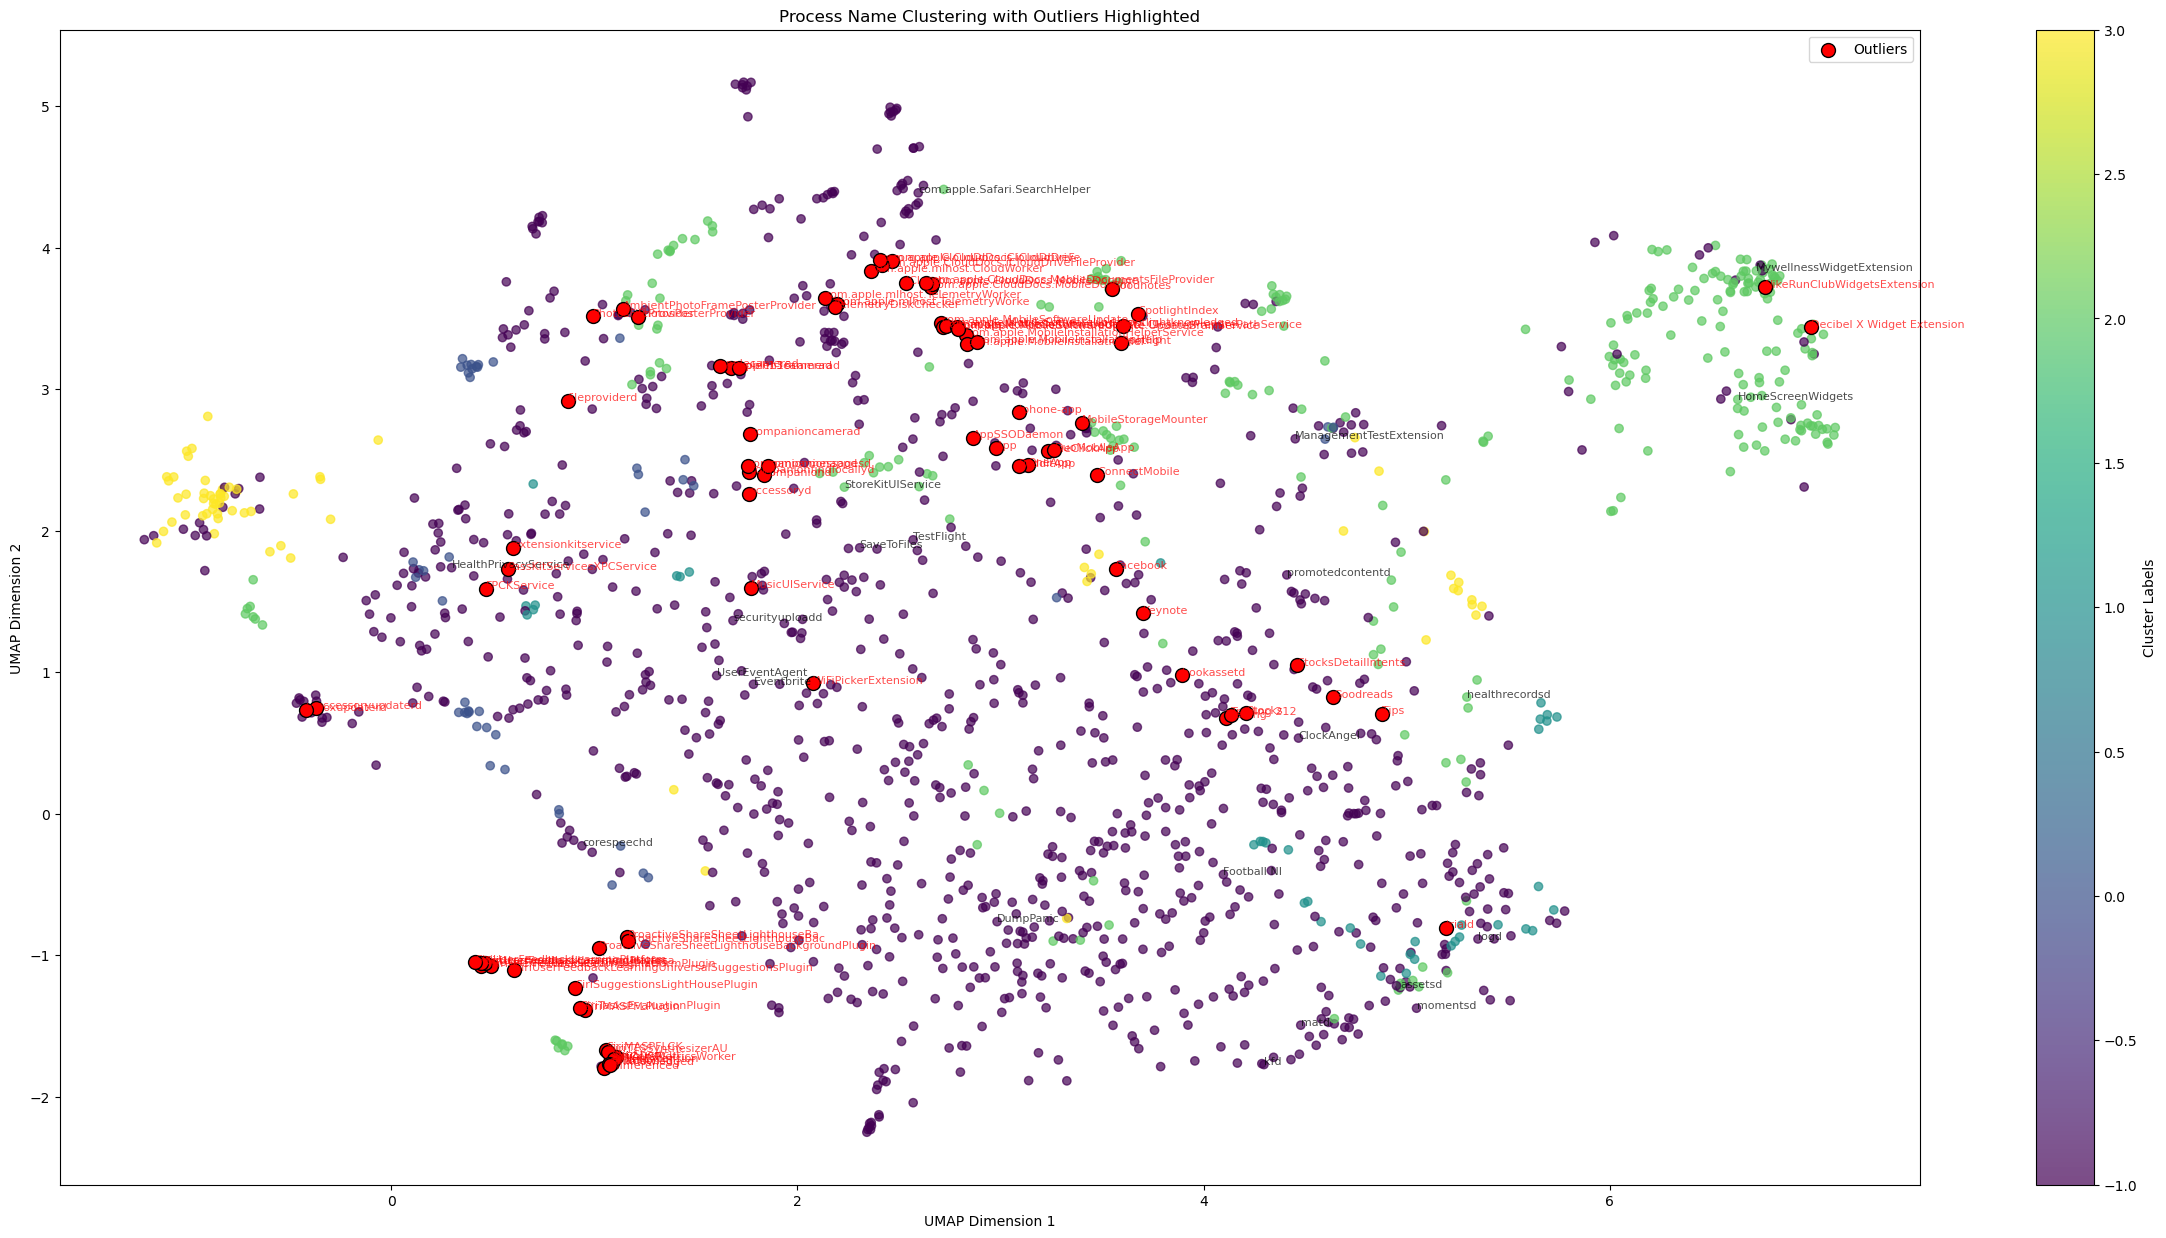

In [36]:

# Apply UMAP for dimensionality reduction
umap = UMAP(n_neighbors=20, n_components=2, min_dist=0.1, metric='cosine')
umap_embeddings = umap.fit_transform(normalized_embeddings)
# Convert proc_names to a list for indexing
proc_names_list = proc_names.tolist()

# Create the plot
plt.figure(figsize=(30, 15))

# Scatter plot with transparency
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)

# Add color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Labels')

# Display only a subset of process names to reduce clutter
for i, txt in enumerate(proc_names_list):
    if np.random.rand() > 0.99:  # Display approximately 2% of labels
        plt.annotate(txt, (umap_embeddings[i, 0], umap_embeddings[i, 1]), fontsize=8, alpha=0.7)

# Highlight outliers
outlier_indices = [proc_names_list.index(name) for name in outliers['procName'] if name in proc_names_list]
plt.scatter(umap_embeddings[outlier_indices, 0], umap_embeddings[outlier_indices, 1], 
            c='red', edgecolor='k', s=100, label='Outliers')

# Annotate some of the outliers
for i in outlier_indices:
    plt.annotate(proc_names_list[i], (umap_embeddings[i, 0], umap_embeddings[i, 1]), fontsize=8, color='red', alpha=0.7)

# Add labels and title
plt.title('Process Name Clustering with Outliers Highlighted')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Show legend
plt.legend()

# Display the plot
plt.show()

In [37]:
#!pip install plotly-express

In [38]:
# Apply UMAP for dimensionality reduction
umap = UMAP(n_neighbors=20, n_components=2, min_dist=0.1, metric='cosine')
umap_embeddings = umap.fit_transform(normalized_embeddings)
# Convert proc_names to a list for indexing
proc_names_list = proc_names.tolist()

# Create a DataFrame for the embeddings
df_embeddings = pd.DataFrame(umap_embeddings, columns=['UMAP_1', 'UMAP_2'])
df_embeddings['procName'] = proc_names_list
df_embeddings['cluster'] = cluster_labels

# Mark outliers in the DataFrame
df_embeddings['outlier'] = df_embeddings['procName'].isin(outliers['procName'])
df_embeddings['outlier_score'] = df_embeddings.apply(
    lambda row: outliers[outliers['procName'] == row['procName']]['outlier_score'].values[0] 
    if row['procName'] in outliers['procName'].values 
    else None, axis=1)

# Create the interactive plot
fig = px.scatter(
    df_embeddings, x='UMAP_1', y='UMAP_2', color='cluster', 
    hover_data=['procName', 'outlier_score'],
    title='Process Name Clustering with Outliers Highlighted',
    labels={'UMAP_1': 'UMAP Dimension 1', 'UMAP_2': 'UMAP Dimension 2'},
    opacity=0.7
)

# Highlight outliers
outliers_data = df_embeddings[df_embeddings['outlier']]
fig.add_scatter(
    x=outliers_data['UMAP_1'], y=outliers_data['UMAP_2'],
    mode='markers', marker=dict(color='red', size=10, line=dict(width=2, color='DarkSlateGrey')),
    name='Outliers', text=outliers_data['procName']
)

# Update layout
fig.update_layout(
    legend=dict(title='Clusters'),
    xaxis_title='UMAP Dimension 1',
    yaxis_title='UMAP Dimension 2'
)

# Show the plot
fig.show()

# 
fig.write_html("procName_outliers.html")

### Explanation of the Plot for Non-Technical Stakeholders

#### Overview
The plot you see is a visual representation of different processes (or apps) running on mobile devices. It's designed to help us identify patterns and outliers among these processes, which is crucial for detecting potential threats.

#### Key Components of the Plot

1. **Dots Represent Processes:**
   - Each dot on the plot represents a different process or app running on a mobile device.
   - The position of the dots is determined by their characteristics, with similar processes positioned closer together.

2. **Colors Indicate Clusters:**
   - The colors of the dots show how these processes are grouped into clusters. Processes within the same cluster share similar characteristics.
   - Think of clusters as groups of processes that behave similarly or belong to the same category.

3. **Red Dots are Outliers:**
   - The red dots with black edges are outliers, which means they don't fit well into any cluster. These outliers are unusual processes that need special attention.
   - Outliers can be benign, like rare but legitimate apps, or they could be potential threats that warrant further investigation.

4. **Labeled Outliers:**
   - Some of the outliers are labeled with their names to make it easier to identify and investigate them. These labels help us quickly spot and focus on potentially suspicious processes.

#### Why This is Important

- **Cluster Identification:**
  - By grouping similar processes together, we can understand the normal behavior of processes on mobile devices. This helps in identifying what is typical and what is not.
  
- **Outlier Detection:**
  - Outliers often indicate something unusual. In mobile threat hunting, these unusual processes can be indicators of malicious activity, like malware or unauthorized apps.

#### Practical Example

Imagine we're monitoring a fleet of mobile devices. Most apps like email, social media, and common utilities will group together in clusters based on their normal behavior. If we suddenly see an unfamiliar app (red dot) that doesn't fit into any cluster, it could be a new piece of malware or an unauthorized app trying to access sensitive information.

#### What We Can Do Next

1. **Investigate Outliers:**
   - Each red dot should be investigated to determine if it poses a threat. We can look at its behavior, origin, and permissions to decide if it's harmful.
   
2. **Monitor Clusters:**
   - By keeping an eye on the clusters, we can quickly detect any significant changes or new clusters forming, which might indicate emerging threats.

3. **Refine Our Detection:**
   - Continuously improve our models to better distinguish between normal and suspicious behavior, reducing false alarms and improving threat detection accuracy.

This plot is a tool that helps us keep our mobile devices secure by visually highlighting what processes are running and identifying potential threats quickly and efficiently.